# Training the Center Surround Model with nndichromacy

In [1]:
import os
import datajoint as dj

dj.config["database.host"] = '18.198.155.36'
dj.config["enable_python_native_blobs"] = True
dj.config['nnfabrik.schema_name'] = "nnfabrik_color_mei"
dj.config["display.limit"] = 70

dj.config['database.user'] = os.environ['DJ_USERNAME']
dj.config['database.password'] = os.environ['DJ_PASSWORD']

In [2]:
import nnfabrik
from nnfabrik import main, builder

import torch
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

Connecting mohammad@18.198.155.36:3306


# Model Config

In [3]:
# initial guess
model_fn = 'nndichromacy.models.se_core_center_surround'
model_config = {'pad_input': False,
             'stack': -1,
             'layers': 4,
             'input_kern': 7,
             'gamma_input': 6.3831,
             'gamma_readout': 0.0076,
             'hidden_dilation': 1,
             'hidden_kern': 5,
             'hidden_channels': 64,
             'n_se_blocks': 0,
             'depth_separable': True,
             'init_mu_range': 0.3,
             'shifter': True,
             'shift_layers': 3}

In [4]:
# Model().add_entry(model_fn, model_config, model_comment="Center Surround model, initial guess")

# Trainer Config

In [5]:
# trainer_fn, trainer_config = (Trainer & dict(trainer_hash='0d06f037501e129d11aa288d8f22788f')).fetch1("trainer_fn", "trainer_config")
trainer_fn,  trainer_config = ('nndichromacy.training.standart_trainer',
 {'max_iter': 100,
  'verbose': False,
  'lr_decay_steps': 4,
  'avg_loss': False,
  'lr_init': 0.009029494706714493})

# Dataset Config

In [6]:
#dataset_fn, dataset_config = (Dataset & dict(dataset_hash='5b2e34c86946db3348ba35969da54b39')).fetch1("dataset_fn", "dataset_config")
# dataloaders = (Dataset & dict(dataset_hash='5b2e34c86946db3348ba35969da54b39')).get_dataloader()

dataset_fn, dataset_config = ('nndichromacy.datasets.static_loaders',
 {'paths': ['static26470-3-8-ColorImageNet-104e446ed0128d89c639eef0abe4655b.zip'],
  'normalize': True,
  'neuron_ids': [],
  'include_behavior': False,
  'select_input_channel': None,
  'include_eye_position': False,
  'include_px_position': False,
  'batch_size': 128,
  'exclude': None,
  'file_tree': True,
  'include_trial_info_keys': []})

data_key = "26470-3-8"

# Load everything

In [7]:
from nnfabrik.builder import get_data, get_model, get_trainer

In [8]:
dataloaders = get_data(dataset_fn, dataset_config )
model = get_model(model_fn, model_config, dataloaders, seed=1)
trainer = get_trainer(trainer_fn,  trainer_config)

static26470-3-8-ColorImageNet-104e446ed0128d89c639eef0abe4655b exists already. Not unpacking static26470-3-8-ColorImageNet-104e446ed0128d89c639eef0abe4655b.zip


/usr/local/lib/python3.8/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [9]:
model.readout[data_key].surround_on = False

In [10]:
model.readout[data_key].center_on, model.readout[data_key].surround_on

(True, False)

In [11]:
model.readout.gamma_readout

0.0076

# Train the model

In [27]:
score, output, state_dict = trainer(model, dataloaders, seed=1)

Epoch 1: 100%|██████████| 39/39 [00:04<00:00,  8.48it/s]


[001|00/05] ---> 0.045794788748025894


Epoch 2: 100%|██████████| 39/39 [00:04<00:00,  8.48it/s]


[002|00/05] ---> 0.10464014112949371


Epoch 3: 100%|██████████| 39/39 [00:04<00:00,  8.63it/s]


[003|00/05] ---> 0.13647137582302094


Epoch 4: 100%|██████████| 39/39 [00:04<00:00,  8.48it/s]


[004|00/05] ---> 0.17879357933998108


Epoch 5: 100%|██████████| 39/39 [00:04<00:00,  8.61it/s]


[005|00/05] ---> 0.19253593683242798


Epoch 6: 100%|██████████| 39/39 [00:04<00:00,  8.62it/s]


[006|00/05] ---> 0.21115317940711975


Epoch 7: 100%|██████████| 39/39 [00:04<00:00,  8.59it/s]


[007|00/05] ---> 0.2237708419561386


Epoch 8:  38%|███▊      | 15/39 [00:01<00:02,  8.54it/s]


KeyboardInterrupt: 

In [28]:
model.eval();

In [29]:
from nndichromacy.utility.measures import get_correlations

In [30]:
correlations = get_correlations(model, dataloaders["test"], device="cuda",  as_dict=False, per_neuron=True)

In [31]:
correlations.mean()

0.20974134

---

In [32]:
cw_init = model.readout[data_key].center_weights_init.cpu().data.numpy()
sw_init = model.readout[data_key].surround_weights_init.cpu().data.numpy()
cw = model.readout[data_key].center_weights.cpu().data.numpy()
sw = model.readout[data_key].surround_weights.cpu().data.numpy()

<ipython-input-33-406680ec7c89>:25: UserWarning: Attempting to set identical bottom == top == -0.0 results in singular transformations; automatically expanding.
  ax.set(xlim=xlim, ylim=ylim)


[(-0.11689972877502441, 2.1168997287750244), (-0.05, 0.05)]

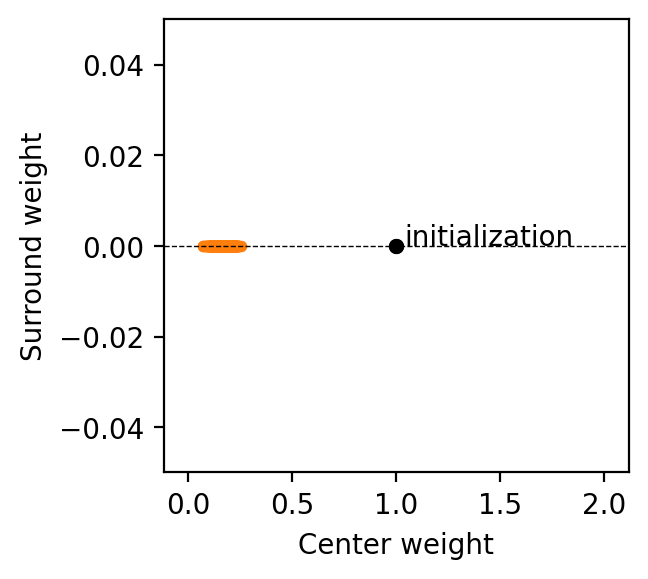

In [33]:
fig, ax = plt.subplots(figsize=(3, 3), dpi=200)
point_size = 10

ax.scatter(cw_init, sw_init, s=point_size)

ax.scatter(cw, sw, s=point_size)
ax.set_xlabel("Center weight")
ax.set_ylabel("Surround weight")

x_max = 1 + np.abs(1 - cw).max()
x_min = 1 - np.abs(1 - cw).max()
y_max = max(np.abs(sw.max()),  np.abs(sw.min()))
y_min = -y_max
x_drange = x_max - x_min
y_drange = y_max - y_min

xlim = (x_min - .1*x_drange, x_max + .1*x_drange)
ylim = (y_min - .1*y_drange, y_max + .1*y_drange)

ax.plot(xlim, [0, 0], c='k', ls='--', lw=.5)
ax.plot([1, 1], ylim, c='k', ls='--', lw=.5)
ax.scatter([1, 1], [0, 0], c='k', s=point_size*2)
ax.text(1 + .02*x_drange, 0 + .02*y_drange, "initialization", c='k')

ax.set(xlim=xlim, ylim=ylim)

In [28]:
# !pip install figrid

In [34]:
def normalize(aa):
    bb = aa - aa.min()
    return bb / bb.max()

In [35]:
neuron_idx = 1082 # 0, 358, 1082

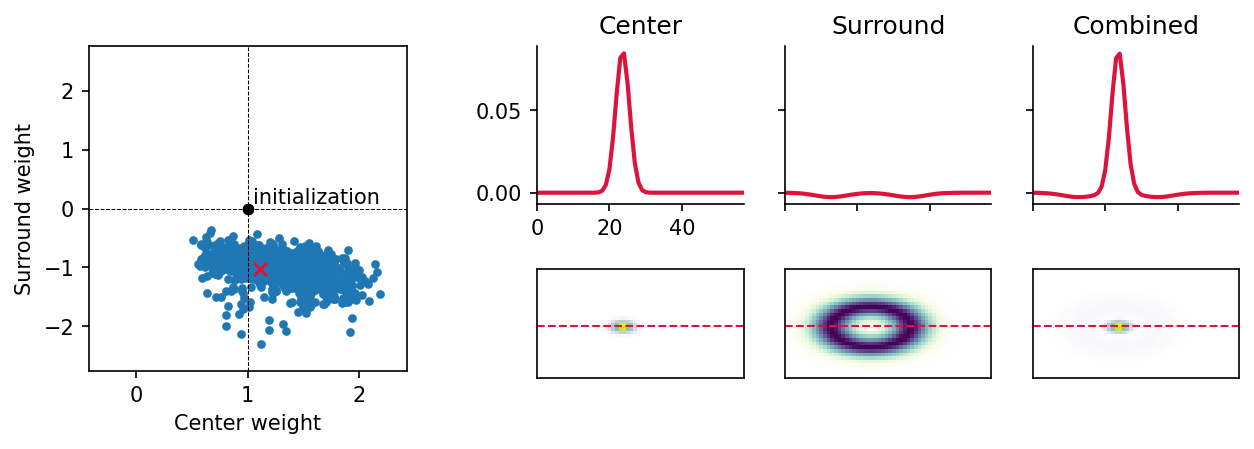

In [38]:
import figrid as fg

fig = plt.figure(figsize=(11, 3.5), dpi=150)
ax = fg.place_axes_on_grid(fig, xspan=[0.05, 0.3], yspan=[0.05, 0.87])
axes = np.array([fg.place_axes_on_grid(fig, xspan=[0.4, 0.95], yspan=[0.05, 0.45], dim=[1, 3], sharey=True, sharex=True), 
                 fg.place_axes_on_grid(fig, xspan=[0.4, 0.95], yspan=[0.55, 0.95], dim=[1, 3])])



ax.scatter(cw, sw, s=point_size)
ax.set_xlabel("Center weight")
ax.set_ylabel("Surround weight")

ax.scatter(cw[neuron_idx], sw[neuron_idx], color="crimson", s=40, marker="x", label="Selected neuron")

x_max = 1 + np.abs(1 - cw).max()
x_min = 1 - np.abs(1 - cw).max()
y_max = max(np.abs(sw.max()),  np.abs(sw.min()))
y_min = -y_max
x_drange = x_max - x_min
y_drange = y_max - y_min

xlim = (x_min - .1*x_drange, x_max + .1*x_drange)
ylim = (y_min - .1*y_drange, y_max + .1*y_drange)

ax.plot(xlim, [0, 0], c='k', ls='--', lw=.5)
ax.plot([1, 1], ylim, c='k', ls='--', lw=.5)
ax.scatter([1, 1], [0, 0], c='k', s=point_size*2)
ax.text(1 + .02*x_drange, 0 + .02*y_drange, "initialization", c='k')

ax.set(xlim=xlim, ylim=ylim)


center_mask = model.readout[data_key].mask()["center"][neuron_idx].cpu().data.numpy()
surround_mask = model.readout[data_key].mask()["surround"][neuron_idx].cpu().data.numpy()
h, w = center_mask.shape
h_mu, w_mu = model.readout[data_key].mu[neuron_idx].cpu().data.numpy()
h_loc = int(h/2 + h/2 * h_mu)

ax1, ax2, ax3 = axes[1]
ax1.imshow(center_mask, alpha=normalize(np.abs(center_mask)))
ax2.imshow(surround_mask, alpha=normalize(np.abs(surround_mask)))
ax3.imshow(center_mask + surround_mask, alpha=normalize(np.abs(center_mask + surround_mask)))

ax1.hlines(h_loc, 0, w, lw=1, ls='--', color='crimson')
ax2.hlines(h_loc, 0, w, lw=1, ls='--', color='crimson')
ax3.hlines(h_loc, 0, w, lw=1, ls='--', color='crimson')

for ax in axes[1].flat:
    ax.set(xticks=[], yticks=[])

for ax in axes.flat:
    ax.set(xlim=(0, w-1))
    
ax1, ax2, ax3 = axes[0]
ax1.plot(center_mask[h_loc, :], c='crimson', lw=2)
ax2.plot(surround_mask[h_loc, :], c='crimson', lw=2)
ax3.plot((center_mask + surround_mask)[h_loc, :], c='crimson', lw=2)

titles = ['Center', "Surround", "Combined"]
for i, ax in enumerate(axes[0].flat):
    sns.despine(top=True, ax=ax)
    if i > 0:
        ax.set(xticklabels=[])
        
    ax.set_title(titles[i])

## How to turn center/surround off and on?

In [136]:
model.readout[data_key].center_on = False

In [137]:
model.readout[data_key].center_on 

False

In [140]:
model.readout[data_key].surround_on = True

In [141]:
model.readout[data_key].surround_on 

True

## How are the masks generated?

In [83]:
mask = model.readout[data_key].mask()

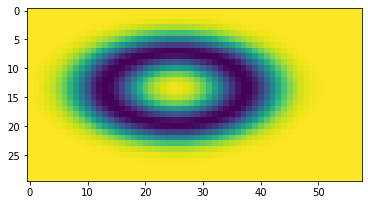

In [89]:
plt.imshow(mask['surround'][0].cpu().data.numpy())

In [90]:
def cart2pol_np(x, y):
    """
    Change cartesian coordinates to polar
    """
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return rho, phi

In [101]:
xx, yy = np.meshgrid(np.linspace(-1, 1, 500), np.linspace(-1, 1, 300))

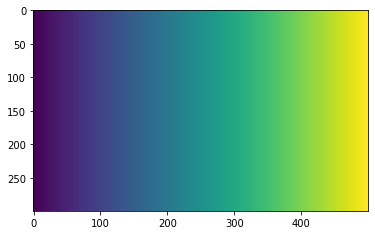

In [102]:
plt.imshow(xx)

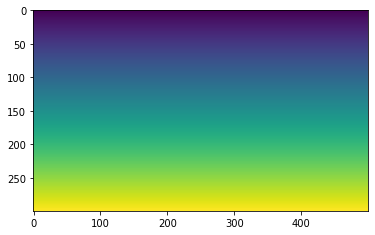

In [103]:
plt.imshow(yy)

In [104]:
rho, phi = cart2pol_np(xx, yy)

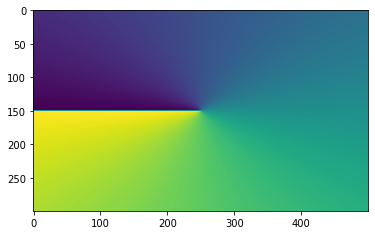

In [105]:
plt.imshow(phi)

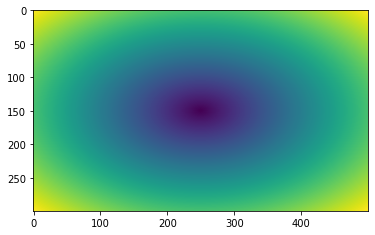

In [107]:
plt.imshow(rho)

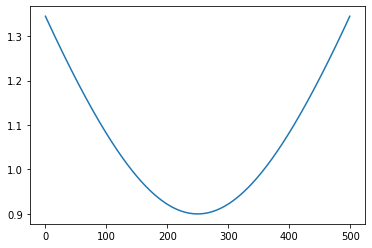

In [108]:
plt.plot(rho[15, :])

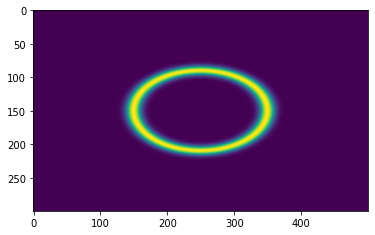

In [117]:
radius = .4
thickness = .001
plt.imshow(np.exp(-0.5 * (rho - radius) ** 2 / thickness))

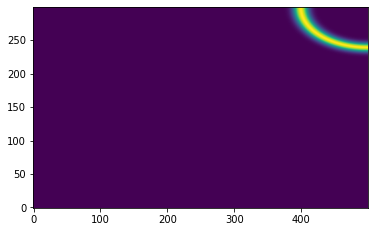

In [120]:
radius = .4
thickness = .001
x = 1
y = 1

rho, phi = cart2pol_np(xx - x, yy - y)
plt.imshow(np.exp(-0.5 * (rho - radius) ** 2 / thickness), origin="lower")